## Установка, импорт библиотек и подключение диска

In [2]:
%%capture
!pip install rembg
from rembg import remove
from PIL import Image
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import zipfile
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, models
import shutil
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Распаковка и предобработка данных
#### Необходимо обучить нейросеть на распознавание жествого английского алфавита
Датасет:  
https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data  


In [3]:
zip_file = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/Язык жестов.zip'
zipfile.ZipFile(zip_file, 'r').extractall()

print(os.listdir())

['.config', 'drive', 'asl_alphabet_test', 'asl_alphabet_train', 'sample_data']


In [4]:
data_root = '/content/asl_alphabet_train/asl_alphabet_train'
data_clean = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/asl_clean'
print(os.listdir(data_root))

['K', 'V', 'P', 'J', 'U', 'R', 'M', 'L', 'T', 'W', 'B', 'X', 'D', 'Z', 'H', 'del', 'G', 'Y', 'A', 'S', 'Q', 'F', 'E', 'I', 'O', 'N', 'space', 'nothing', 'C']


In [5]:
class_names = os.listdir(data_root)
class_names.sort()
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


#### Преобразование исходников: на картинке останется только жест без фона
Каждый жест представляен 3-я тысячами картинок, этого слишком много, долго будет очищаться. Ограничусь 16-ю картинками для каждого жеста. Чтобы увеличить выборку применю аугментацию.

In [17]:
def process_image(input_path, output_path):
    # Удаление фона
    with open(input_path, "rb") as input_file:
      input_data = input_file.read()
      output_data = remove(input_data)
    try:
      # Обнаружение краев жеста и обрезка исходника по контуру
      image = cv2.imdecode(np.frombuffer(output_data, np.uint8),
                           cv2.IMREAD_UNCHANGED)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      blurred = cv2.GaussianBlur(gray, (3, 3), 0)
      T, thresh_img = cv2.threshold(blurred, 20, 255,cv2.THRESH_BINARY)
      _, binary_mask = cv2.threshold(thresh_img, 20, 255, cv2.THRESH_BINARY)
      contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                                     cv2.CHAIN_APPROX_SIMPLE)
      x, y, w, h = cv2.boundingRect(contours[0])
      if (w > 10) and (h > 10):
        cropped_image = image[y:y+h, x:x+w]
        cv2.imwrite(output_path, cropped_image)
      else:
        with open(output_path, "wb") as output_file:
          output_file.write(output_data)
    except:
      # Обработка исключения введена, т.к. в наборе данных присутствет
      # "nothing" - буквально отсутствие жеста, т.е. отстутвие контуров,
      # возникает ошибка
      with open(output_path, "wb") as output_file:
        output_file.write(input_data)

def process_images_in_directory(input_directory):
    # Если обрабатывается обучающая выборка, создам соответствующие
    #  директории для каждого жеста
    if input_directory == 'train':
      for class_name in class_names:
        os.makedirs(os.path.join(data_clean, input_directory, class_name),
                    exist_ok=True)

      for class_name in class_names:
        source_dir = os.path.join(data_root, class_name)
        for i, filename in tqdm(enumerate(os.listdir(source_dir)),
                                desc='{} processing'.format(class_name)):
          if filename.endswith(".jpg"):
            input_path = os.path.join(source_dir, filename)
            output_path = os.path.join(data_clean, input_directory,
                                       class_name, filename)
            process_image(input_path, output_path)
          if i == 15:
            break

    # В случае тестовой выборки обрабатываем каждую картинку
    # и складирую в папку "/test/unlabeled"
    elif input_directory == 'test':
      os.makedirs(os.path.join(data_clean, input_directory, 'unlabeled'),
                  exist_ok=True)
      source_dir = '/content/asl_alphabet_test/asl_alphabet_test'
      for i, filename in tqdm(enumerate(os.listdir(source_dir)),
                              desc='Test processing'):
        if filename.endswith(".jpg"):
          input_path = os.path.join(source_dir, filename)
          output_path = os.path.join(data_clean, input_directory,
                                     'unlabeled', filename)
          process_image(input_path, output_path)

# Необходимо изменить класс, чтобы с каждым тестовым изображением шла доп. инфа о его пути.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
process_images_in_directory('test')
process_images_in_directory('train')

Test processing: 28it [01:09,  2.47s/it]
A processing: 15it [00:39,  2.61s/it]
B processing: 15it [00:38,  2.60s/it]
C processing: 15it [00:42,  2.85s/it]
D processing: 15it [00:40,  2.70s/it]
E processing: 15it [00:39,  2.66s/it]
F processing: 15it [00:39,  2.63s/it]
G processing: 15it [00:39,  2.63s/it]
H processing: 15it [00:39,  2.64s/it]
I processing: 15it [00:39,  2.61s/it]
J processing: 15it [00:39,  2.60s/it]
K processing: 15it [00:38,  2.57s/it]
L processing: 15it [00:38,  2.58s/it]
M processing: 15it [00:39,  2.61s/it]
N processing: 15it [00:39,  2.63s/it]
O processing: 15it [00:39,  2.63s/it]
P processing: 15it [00:39,  2.62s/it]
Q processing: 15it [00:38,  2.59s/it]
R processing: 15it [00:39,  2.65s/it]
S processing: 15it [00:40,  2.67s/it]
T processing: 15it [00:39,  2.64s/it]
U processing: 15it [00:39,  2.66s/it]
V processing: 15it [00:41,  2.75s/it]
W processing: 15it [00:40,  2.67s/it]
X processing: 15it [00:40,  2.69s/it]
Y processing: 15it [00:39,  2.65s/it]
Z process

#### Трансформация изображений.  
Здесь каждое train изображение отражу по горизонтали и добавлю перспективу. Далее применяю к нему "базовую" аугментацию - приведение к размеру 96х96*, преобразование в тензор и нормализация. Наполняю full_dataset неаугментированными и аугментированными изображениями.  
Делю full_dataset на train_dataset и val_dataset как 80:20.
К test применяю только базовое преобразование.  
  
*Оказалось, что такое преобразование позитивно влияет на процесс обучения. Видимо предварительное уменьшение картинки до 96х96 подчеркивает на ней важные паттерны. Когда картинка загоняется в ResNet она автоматически апскейлится до 224х224.

In [22]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/asl_clean/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/asl_clean/test'

In [23]:
# Необходимые аугментации
augments = [transforms.RandomHorizontalFlip(p=1.0),
            transforms.RandomPerspective(distortion_scale=0.3, p=1.0)
            ]
base = [transforms.Resize(size=(96,96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]

# Создание полного train датасета и test датасета
test_dataset = ImageFolderWithPaths(test_dir, transforms.Compose(base))
full_dataset = torchvision.datasets.ImageFolder(train_dir,
                                                transforms.Compose(base))
for i in augments:
    aug = transforms.Compose([transforms.RandomRotation(15)] + [i] + base)
    full_dataset += torchvision.datasets.ImageFolder(train_dir, aug)

# Разделение полного датасета на train и val
# Разделение индексов для каждого фолда (здесь 5 фолдов)
fold_size = len(full_dataset) // 5
fold_indices = [list(range(i * fold_size,
                           (i + 1) * fold_size)) for i in range(5)]

# Первый фолд как пример
train_indices = [item for sublist in fold_indices[1:] for item in sublist]
val_indices = fold_indices[0]

# Создание подмножеств для обучения и валидации
train_dataset = torch.utils.data.Subset(full_dataset, indices=train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, indices=val_indices)

# Создание dataloader'ов
batch_size = 64
num_workers = 2
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers,
                                               drop_last=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             num_workers=num_workers,
                                             drop_last=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=num_workers,
                                              drop_last=False)

print('Длина train: ', len(train_dataset), '; Количество батчей: ',
      len(train_dataloader), sep='')
print('Длина val: ', len(val_dataset), '; Количество батчей: ',
      len(val_dataloader), sep='')
print('Длина test: ', len(test_dataset), '; Количество батчей: ',
      len(test_dataloader), sep='')

Длина train: 920; Количество батчей: 14
Длина val: 230; Количество батчей: 3
Длина test: 28; Количество батчей: 1


#### Визуализация преобразования

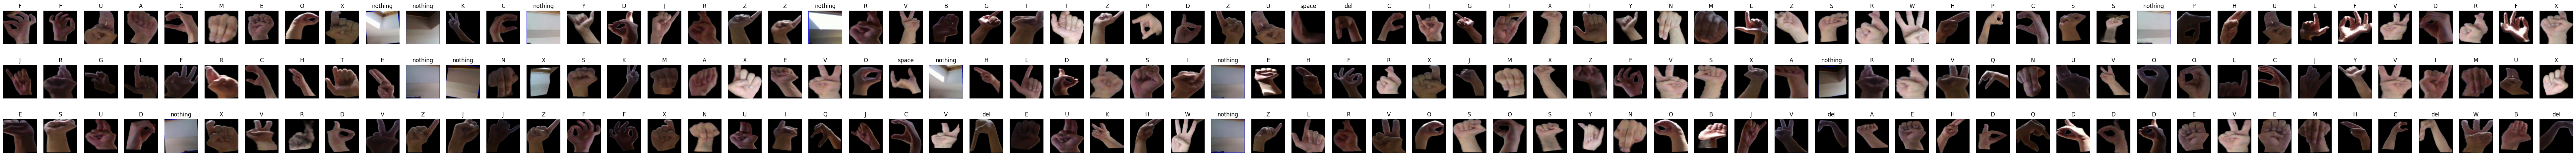

In [24]:
plt.figure(figsize=(100, 6))

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

number_of_batches = 3
for i in range(number_of_batches):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        plt.subplot(number_of_batches, len(X_batch), i * len(X_batch) + j + 1)
        plt.title(class_names[y_batch[j].item()])
        plt.axis('off')
        plt.imshow((X_batch[j].permute(1, 2, 0).numpy() * std + mean).clip(0, 1))

## Реализация обучения

In [25]:
def train_model(model, loss, optimizer, num_epochs):

    epoch_loss_history_train = []
    epoch_acc_history_train = []
    epoch_loss_history_val = []
    epoch_acc_history_val = []

    for epoch in range(num_epochs):
      print('{}/{}'.format(epoch + 1, num_epochs), flush=True)
      for phase in ['train', 'val']:
        if phase == 'train':
          dataloader = train_dataloader
          model.train()
        else:
          dataloader = val_dataloader
          model.eval()

        running_loss = 0.0
        running_acc = 0.0

        for inputs, labels in dataloader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)
            if phase == 'train':
              loss_value.backward()
              optimizer.step()

          running_loss += loss_value.item()
          running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        if phase == 'train':
          epoch_loss_history_train.append([epoch_loss])
          epoch_acc_history_train.append([epoch_acc.data.cpu()])
        else:
          epoch_loss_history_val.append([epoch_loss])
          epoch_acc_history_val.append([epoch_acc.data.cpu()])

        print('Phase: {} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                          epoch_acc), flush=True)

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), epoch_loss_history_train, c='g',
             label='train')
    plt.plot(range(1, num_epochs + 1), epoch_loss_history_val, c='r',
             label='val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), epoch_acc_history_train, c='g',
             label='train')
    plt.plot(range(1, num_epochs + 1), epoch_acc_history_val, c='r',
             label='val')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

    return model

## Обучение ResNet50 на неполной выборке

In [ ]:
torch.manual_seed(0)

model = models.resnet50()

for param in model.parameters():
  param.requires_grad = True

classifier = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,30)
    )

model.fc = classifier
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5, amsgrad=True)

1/100
Phase: train Loss: 3.3665 Acc: 0.0513
Phase: val Loss: 3.3839 Acc: 0.0000
2/100
Phase: train Loss: 3.2279 Acc: 0.0826
Phase: val Loss: 3.3842 Acc: 0.0000
3/100
Phase: train Loss: 3.0603 Acc: 0.1306
Phase: val Loss: 3.2810 Acc: 0.0260
4/100
Phase: train Loss: 2.9007 Acc: 0.1596
Phase: val Loss: 3.2353 Acc: 0.0417
5/100
Phase: train Loss: 2.8098 Acc: 0.1685
Phase: val Loss: 3.8867 Acc: 0.0156
6/100
Phase: train Loss: 2.6420 Acc: 0.2188
Phase: val Loss: 2.9944 Acc: 0.1094
7/100
Phase: train Loss: 2.3886 Acc: 0.2812
Phase: val Loss: 2.7498 Acc: 0.1719
8/100
Phase: train Loss: 2.1571 Acc: 0.3315
Phase: val Loss: 2.9859 Acc: 0.1042
9/100
Phase: train Loss: 2.0315 Acc: 0.3616
Phase: val Loss: 2.1910 Acc: 0.2708
10/100
Phase: train Loss: 1.8538 Acc: 0.4408
Phase: val Loss: 2.2254 Acc: 0.1927
11/100
Phase: train Loss: 1.6790 Acc: 0.4498
Phase: val Loss: 2.6674 Acc: 0.1823
12/100
Phase: train Loss: 1.5516 Acc: 0.5022
Phase: val Loss: 2.0243 Acc: 0.2917
13/100
Phase: train Loss: 1.3227 Acc:

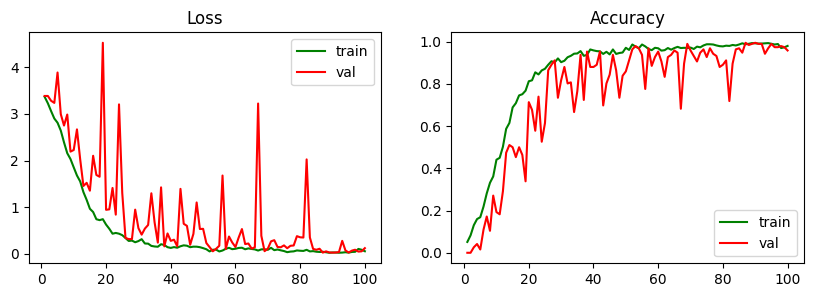

In [ ]:
torch.manual_seed(0)
train_model(model, loss, optimizer,
            num_epochs=100);

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim=1).data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths,
                                        'label': test_predictions})

submission_df['label'] = [class_names[i] for i in test_predictions]
submission_df['id'] = submission_df['id'].str.replace('/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/asl_clean/test/unlabeled/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.sort_values(by='id')
submission_df.head(28)

<ipython-input-65-d320081405ce>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
G_test,G
H_test,H
I_test,I
J_test,J
K_test,K
L_test,L
M_test,N
N_test,N
O_test,O


## Процесс дообучения ResNet50 на неполной выборке


### Изменение архитектуры нейросети  
Я заморожу первые 3 слоя, включу обучение для 4-го и изменю классификатор.  
ResNet50 была выбрана после теста ResNet18. Последняя показывала плохой результат (accuracy < 0.70) с любыми гиперпараметрами.

In [27]:
torch.manual_seed(0)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for layer in [model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False
for layer in [model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

classifier = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,30)
    )

model.fc = classifier
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.layer4.parameters()) + \
                             list(model.fc.parameters()), lr=10**-3.5, amsgrad=True)

1/10
Phase: train Loss: 3.3111 Acc: 0.1250
Phase: val Loss: 3.2681 Acc: 0.0573
2/10
Phase: train Loss: 2.6519 Acc: 0.3638
Phase: val Loss: 2.6225 Acc: 0.2708
3/10
Phase: train Loss: 1.5800 Acc: 0.6562
Phase: val Loss: 1.6879 Acc: 0.5573
4/10
Phase: train Loss: 0.7329 Acc: 0.8348
Phase: val Loss: 0.6114 Acc: 0.8854
5/10
Phase: train Loss: 0.2661 Acc: 0.9319
Phase: val Loss: 0.1510 Acc: 0.9740
6/10
Phase: train Loss: 0.1384 Acc: 0.9520
Phase: val Loss: 0.1143 Acc: 0.9688
7/10
Phase: train Loss: 0.0828 Acc: 0.9743
Phase: val Loss: 0.0314 Acc: 1.0000
8/10
Phase: train Loss: 0.0626 Acc: 0.9844
Phase: val Loss: 0.0245 Acc: 0.9948
9/10
Phase: train Loss: 0.0229 Acc: 0.9955
Phase: val Loss: 0.0117 Acc: 0.9948
10/10
Phase: train Loss: 0.0308 Acc: 0.9944
Phase: val Loss: 0.0092 Acc: 1.0000


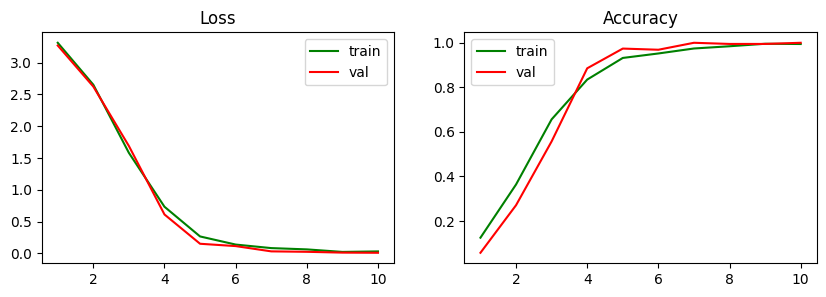

In [28]:
torch.manual_seed(0)
train_model(model, loss, optimizer,
            num_epochs=10);

## Проверка нейросети на тестовой выборке

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim=1).data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

#### Визуализация предсказаний

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = [class_names[i] for i in test_predictions]
submission_df['id'] = submission_df['id'].str.replace('/content/drive/MyDrive/Colab Notebooks/DS/Kaggle/Язык жестов/asl_clean/test/unlabeled/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.sort_values(by='id')
submission_df.head(28)

<ipython-input-57-82e3f8017eb0>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
G_test,G
H_test,H
I_test,I
J_test,J
K_test,K
L_test,L
M_test,M
N_test,N
O_test,O


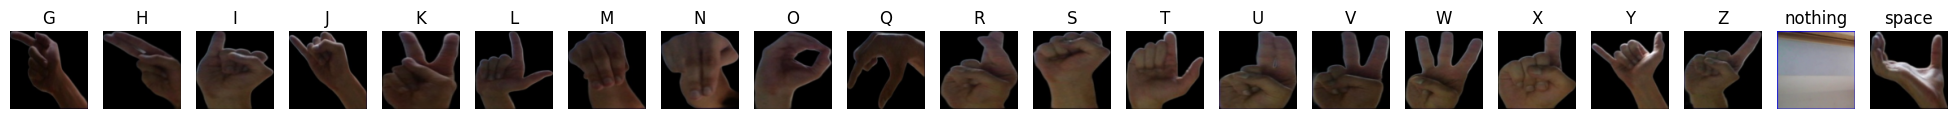

In [ ]:
plt.figure(figsize=(25,10))
def show_input(loader):
  inputs, labels, paths = next(iter(loader))
  for j, (img, pred) in enumerate(zip(inputs, test_predictions[0:len(inputs)])):
    plt.subplot(2, len(inputs), len(inputs) + j + 1)
    plt.title(f'{class_names[pred]}')
    normalized_image = (img.permute(1, 2, 0).numpy() * std + mean).clip(0, 1)
    plt.axis('off')
    plt.imshow(normalized_image)
  plt.show()

show_input(test_dataloader)

## Процесс обучения ResNet50 на полной выборке  
Изображения тажке будут аугментированы, без обрезания фона.

In [ ]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train'
test_dir = '/content/asl_alphabet_test'

# Необходимые аугментации
augments = [transforms.RandomHorizontalFlip(p=1.0),
            transforms.RandomPerspective(distortion_scale=0.3, p=1.0)]
base = [transforms.Resize(size=(96,96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

# Создание полного train датасета и test датасета
test_dataset = ImageFolderWithPaths(test_dir, transforms.Compose(base))
full_dataset = torchvision.datasets.ImageFolder(train_dir, transforms.Compose(base))
for i in augments:
    aug = transforms.Compose([transforms.RandomRotation(10)] + [i] + base)
    full_dataset += torchvision.datasets.ImageFolder(train_dir, aug)

# Разделение полного датасета на train и val
# Разделение индексов для каждого фолда (здесь 5 фолдов)
fold_size = len(full_dataset) // 5
fold_indices = [list(range(i * fold_size, (i + 1) * fold_size)) for i in range(5)]

# Первый фолд как пример
train_indices = [item for sublist in fold_indices[1:] for item in sublist]
val_indices = fold_indices[0]

# Создание подмножеств для обучения и валидации
train_dataset = torch.utils.data.Subset(full_dataset, indices=train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, indices=val_indices)

# Создание dataloader'ов
batch_size = 64
num_workers = 2
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

print('Длина train: ', len(train_dataset), '; Количество батчей: ', len(train_dataloader), sep='')
print('Длина val: ', len(val_dataset), '; Количество батчей: ', len(val_dataloader), sep='')
print('Длина test: ', len(test_dataset), '; Количество батчей: ', len(test_dataloader), sep='')

Длина train: 208800; Количество батчей: 3262
Длина val: 52200; Количество батчей: 815
Длина test: 28; Количество батчей: 1


### Архитектура сети
Такая же, как в предыдущем опыте

In [ ]:
torch.manual_seed(0)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

for layer in [model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False
for layer in [model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

classifier = torch.nn.Sequential(
    torch.nn.Linear(2048, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,30)
    )

model.fc = classifier
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.layer4.parameters()) + \
                             list(model.fc.parameters()), lr=10**-3.5, amsgrad=True)


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

1/2
Phase: train Loss: 0.1375 Acc: 0.9588
Phase: val Loss: 0.0188 Acc: 0.9940
2/2
Phase: train Loss: 0.0161 Acc: 0.9949
Phase: val Loss: 0.0029 Acc: 0.9991


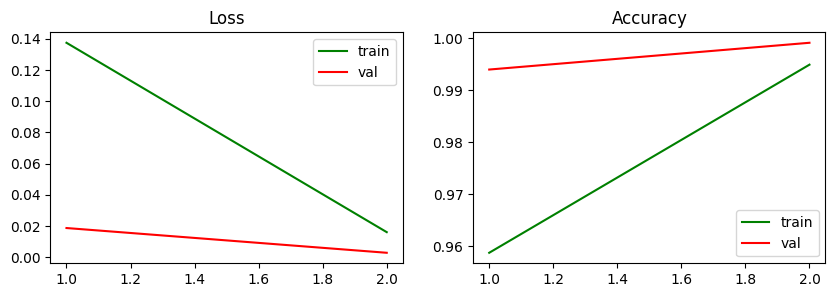

In [ ]:
torch.manual_seed(0)
train_model(model, loss, optimizer,
            num_epochs=2);

Как можно заметить, accuracy как для обучающей, так и для валидационной выборки почти сразу довольно высок. Скорее всего это происходит из-за отсутствия сильного разнообразия в данных, т.е. сеть склонна к простому запоминанию данных - склонна к переобучению.  
Однако это ей не мешает показывать максимальную точность на тестовой выборке.

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(preds.argmax(dim=1).data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

#### Визуализация предсказаний

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = [class_names[i] for i in test_predictions]
submission_df['id'] = submission_df['id'].str.replace('/content/asl_alphabet_test/asl_alphabet_test/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.sort_values(by='id')
submission_df.head(28)

<ipython-input-29-f59866332ed3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  submission_df['id'] = submission_df['id'].str.replace('.jpg', '')


,label
id,
A_test,A
B_test,B
C_test,C
D_test,D
E_test,E
F_test,F
G_test,G
H_test,H
I_test,I


## Основные выводы
#### Обучающая выборка
Использование малой части исходной обучающей выборки также способно показывай высокую точность модели, как и использование всего датасета. Разница лишь в том, что в первом случае больше времени тратится на предобработку изображений, нежели на обучени сети, а во втором нет предобработки, но много времени уходит на само обучение.
#### Выбор сети
Использование предобученной сети целесообразно, т.к. общие патерны изображений сеть уже "знает". Ей остается лишь доучиться на предложенной выборке и научиться првильно классифицировать данные.  
Выбор полностью необученой сети нецелесообразен, т.к. в итоге сеть недообучается, а loss и accuracy сильно флуктуируют. Сеть путает N и M, и X и U, т.к. эти жесты похожи. Сеть не способна распознать только очертания таргетных жестов.
